In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.xarray
import xmitgcm
import xgcm

In [4]:
rundir ='/rigel/ocp/users/scw2148/tutorial_barotropic_gyre/run'

# there are 72 20-minute timesteps in 24 hours, for the 200 days of the run
# start at 1, since we don't want to read the very first one to avoid glitches
timesteps = 72*np.arange(1,201)

# 360_day calendar doesn't include leap years and every month is 30 days
ds = xmitgcm.open_mdsdataset(rundir, iters=timesteps,
                             delta_t=1200, calendar='360_day',
                             ref_date='0000-01-01 00:00:00')
ds;

/rigel/ocp/projects/conda/envs/pangeo2020/lib/python3.7/site-packages/xmitgcm/mds_store.py:236: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/rigel/ocp/projects/conda/envs/pangeo2020/lib/python3.7/site-packages/xmitgcm/mds_store.py:236: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
op

## 2. Calculate the Stommel solution in the MITgcm tutorial_barotropic_gyre simulation and compare it to the full solution.

In [5]:
π = np.pi
β = 1e-11 # m-1 s-1
a = ds.XG[-1] # a is the size of the domain, so a = ds.XG[-1]
x = ds.XG
y = ds.YG
r = 1e-6 # bottom drag units are   s-1
ϵ = r / (β * a *2) # factor 2 to get epsilon close to 0.04 as in Vallis
τ0 = 0.1/1e3 # N m-2 standard wind stress

In [6]:
# stommel solution
ψ_stom =  (τ0 * π)/β * (1 - (x/a) - np.e**(-x / (a * ϵ)) ) * np.sin(π*y / a) / 1e6

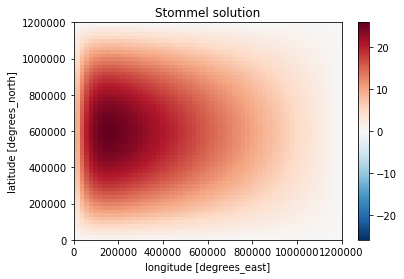

In [7]:
ψ_stom.transpose().plot()
plt.title('Stommel solution')
plt.xlim([0,a])
plt.ylim([0,a]);

### Full solution

In [8]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drF', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(ds, metrics=metrics)
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
Z Axis (periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
T Axis (periodic):
  * center   time
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center

In [9]:
ψ = -grid.cumint(ds.U * ds.drF[0], 'Y', boundary='fill')/1e6

Text(0.5, 1.0, 'Full solution')

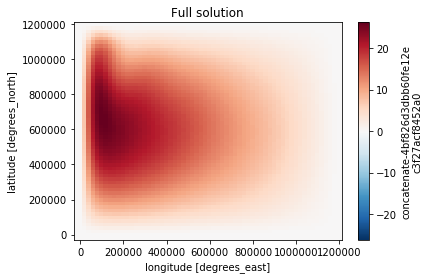

In [10]:
ψ[-1].plot()
plt.title('Full solution')

### Compare to the Stommel

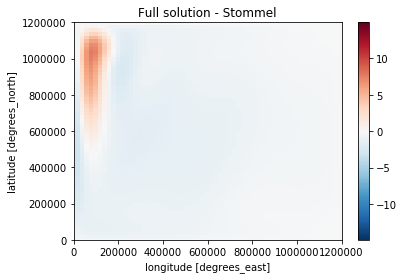

In [11]:
(ψ[-1] - ψ_stom).plot()
plt.xlim([0,a])
plt.ylim([0,a])
plt.title('Full solution - Stommel');

> Stommel's solution underestimates at the western boundary, and maybe because the solution exponentially decays.

## Make new wind stress file in /run2
Use the standard wind stress (0.1 N/m^2)  and also a double-strength wind stress (0.2 N/m^2). You will have to figure out how to write an appropriately formatted binary file.

> The sinusoidal wind-stress variations are defined according to
## $ τ_x(y)=− τ_0 cos(\frac{π y}{L_y} ) $
> For a double-strength wind stress of 0.2 N m-2:

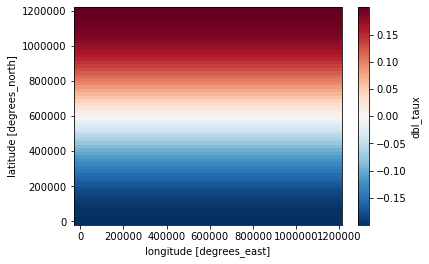

In [12]:
# read zonal wind stress data
taux_data = np.fromfile(f'{rundir}/windx_cosy.bin', dtype='>f4')
cos_y = -taux_data / τ0

τ1 = 0.2/1e3

dbl_taux_data = -τ1 * cos_y
dbl_taux_data.astype('>f4').tofile(f'{rundir}/windx_cosy_double.bin')

dbl_taux_data.shape = ds.rA.shape
ds['dbl_taux'] = ('YC', 'XG'), dbl_taux_data
ds.dbl_taux.plot()

> After running the model, let's apply the new wind stress on Stommel and the full solution

In [13]:
rundir2 ='/rigel/ocp/users/scw2148/tutorial_barotropic_gyre/run2'
# I copied the binary file I made above to run2 in tutorial_barotropic_gyre, so that I don't lose the model outputs from earlier

timesteps = 72*np.arange(1,201)

ds2 = xmitgcm.open_mdsdataset(rundir2, iters=timesteps,
                             delta_t=1200, calendar='360_day',
                             ref_date='0000-01-01 00:00:00')
ds2;

/rigel/ocp/projects/conda/envs/pangeo2020/lib/python3.7/site-packages/xmitgcm/mds_store.py:236: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/rigel/ocp/projects/conda/envs/pangeo2020/lib/python3.7/site-packages/xmitgcm/mds_store.py:236: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
op

> I want to check if the new wind stress input actually made any changes, so I will compare the velocities from the different runs

#### Zonal velocity comparison between different wind stress runs

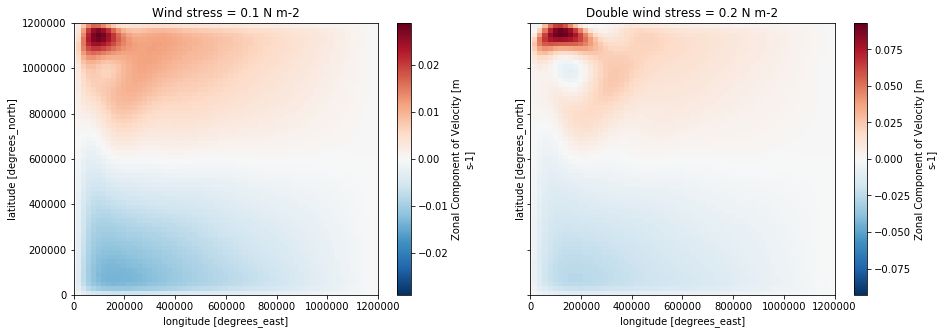

In [14]:
fig, ax = plt.subplots(ncols=2,nrows=1,sharey=True, figsize=(15,5))
ds.U[-1].plot(ax=ax[0])
ds2.U[-1].plot(ax=ax[1])

ax[0].set_title('Wind stress = 0.1 N m-2')
ax[1].set_title('Double wind stress = 0.2 N m-2')

ax[0].set_ylim([0,a])
ax[0].set_xlim([0,a])
ax[1].set_ylim([0,a])
ax[1].set_xlim([0,a]);

#### Meridional velocity comparison between different wind stress runs

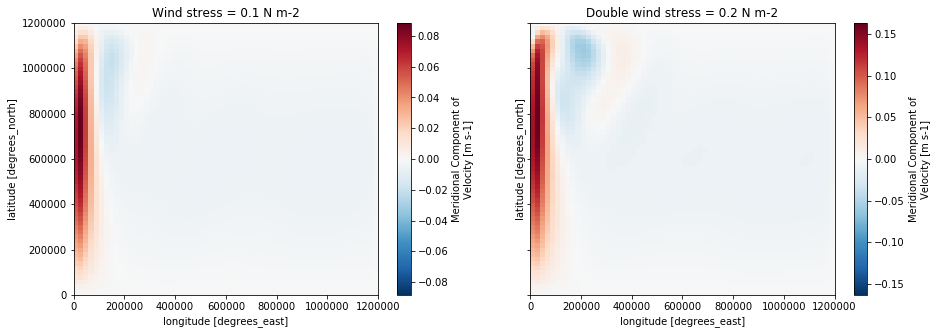

In [15]:
fig, ax = plt.subplots(ncols=2,nrows=1,sharey=True, figsize=(15,5))
ds.V[-1].plot(ax=ax[0])
ds2.V[-1].plot(ax=ax[1])

ax[0].set_title('Wind stress = 0.1 N m-2')
ax[1].set_title('Double wind stress = 0.2 N m-2')

ax[0].set_ylim([0,a])
ax[0].set_xlim([0,a])
ax[1].set_ylim([0,a])
ax[1].set_xlim([0,a]);

## Stommel solution comparison between different wind stress runs

In [16]:
# stommel solution with double-strength wind stress
τ1 = 0.2 / 1e3

ψ_stom2 =  (τ1 * π)/β * (1 - (x/a) - np.e**(-x / (a * ϵ)) ) * np.sin(π*y / a) / 1e6

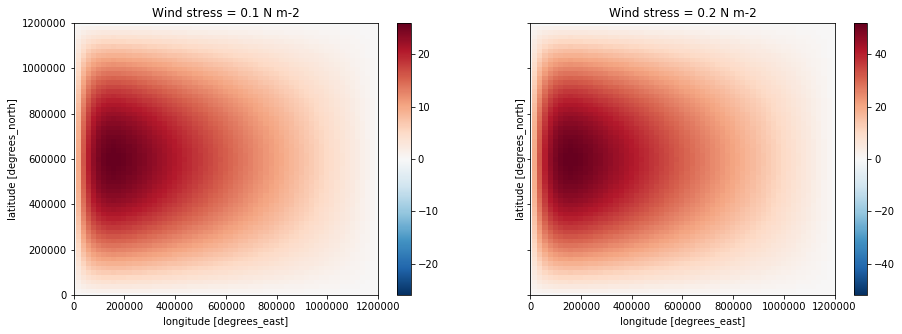

In [17]:
fig ,ax = plt.subplots(ncols=2,nrows=1, sharey=True, figsize=(15,5))

ψ_stom.transpose().plot(ax=ax[0])
ax[0].set_xlim([0,a])
ax[0].set_ylim([0,a])
ax[0].set_title('Wind stress = 0.1 N m-2')

ψ_stom2.transpose().plot(ax=ax[1])
ax[1].set_xlim([0,a])
ax[1].set_ylim([0,a])
ax[1].set_title('Wind stress = 0.2 N m-2');

### Compare full solution to stommel in the double-strength wind stress scenario

In [18]:
ψ2 = -grid.cumint(ds2.U * ds2.drF[0], 'Y', boundary='fill')/1e6

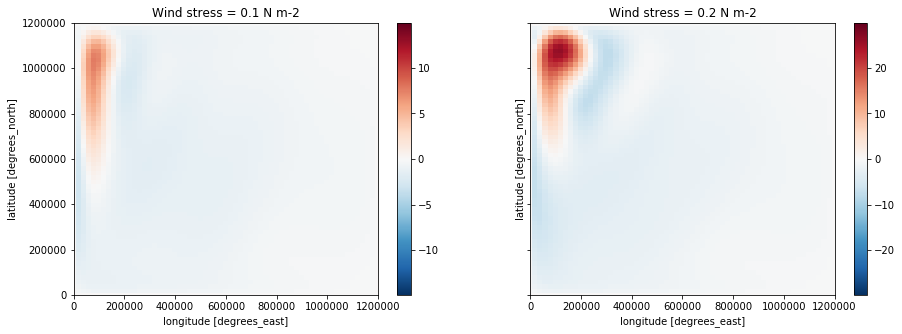

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True, figsize=(15,5))

(ψ[-1] - ψ_stom).plot(ax=ax[0])
ax[0].set_xlim([0,a])
ax[0].set_ylim([0,a])
ax[0].set_title('Wind stress = 0.1 N m-2');

(ψ2[-1] - ψ_stom2).plot(ax=ax[1])
ax[1].set_xlim([0,a])
ax[1].set_ylim([0,a])
ax[1].set_title('Wind stress = 0.2 N m-2');


> Doubling the wind stress appears to double the magnitude of the outputs. At double-strength wind stress, it seems like there is a stronger divergence at the NW boundary between the full solution and the Stommel model.

### 3. Diagnose all terms in the barotropic vorticity budget to the best of your ability. You may wish to use the extra diagnostics I have suggested in the github repo.

> Let's look at the model outputs for each component of the momentum and vorticity budgets

> MITgcm seem to be double counting with Um_Advec and Um_Cori (Um_Advec contains Um_Cori)

In [20]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drF', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(ds, metrics=metrics, periodic=False)
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
T Axis (not periodic):
  * center   time
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center

In [21]:
plt.rcParams['axes.facecolor'] = '0.5'

### Zonal momentum budget

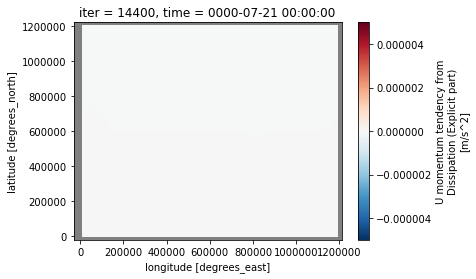

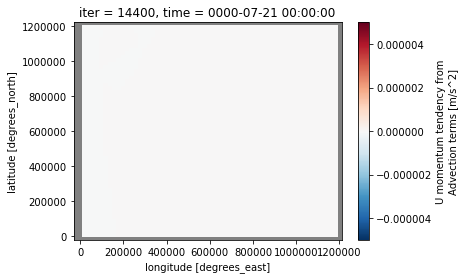

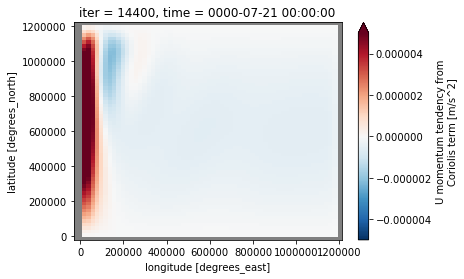

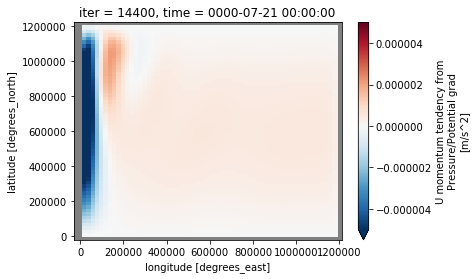

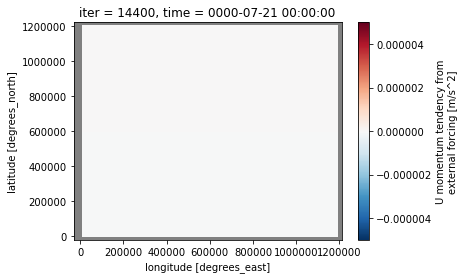

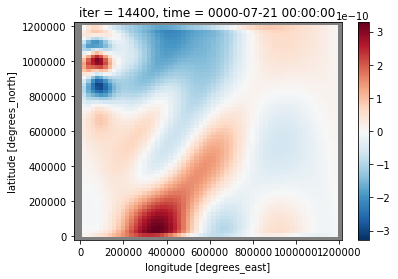

In [22]:
Um_advec_wo_coriolis = ds.Um_Advec - ds.Um_Cori
Um_advec_wo_coriolis.attrs.update(ds.Um_Advec.attrs)

names = ['Dissipation', 'Advection', 'Coriolis', 'Pressure Gradient', 'External Forcing']

terms_U = [ds.Um_Diss, Um_advec_wo_coriolis, ds.Um_Cori, ds.Um_dPhiX , ds.Um_Ext]
sum_terms_U = sum(terms_U)

vmax=5e-6


mask_u = ds.hFacW > 0.

for term in terms_U:
    data = term[-1].where(mask_u)
    plt.figure()
    data.plot(vmax=vmax)
    
    
plt.figure()
sum_terms_U[-1].where(mask_u).plot()

> Final sum of budget components is close to zero

### Meridional momentum budget

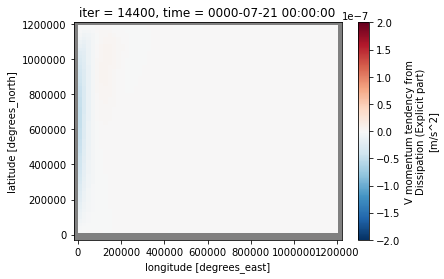

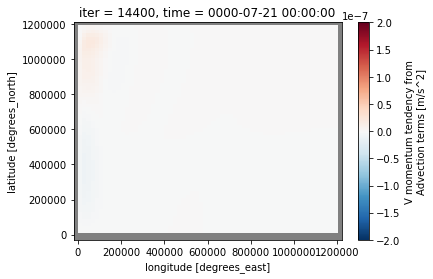

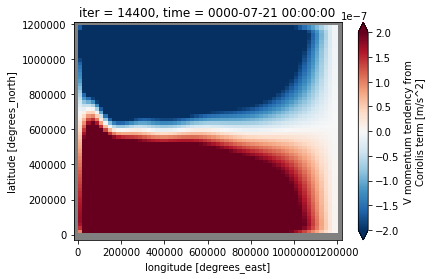

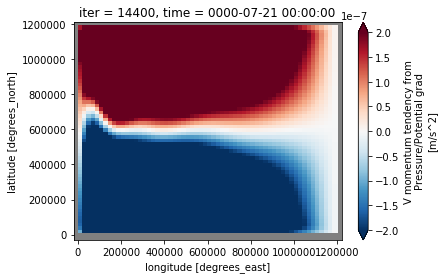

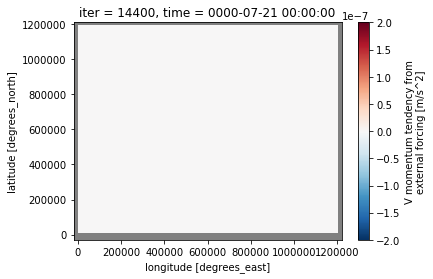

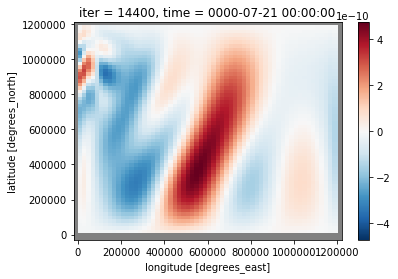

In [23]:
Vm_advec_wo_coriolis = ds.Vm_Advec - ds.Vm_Cori
Vm_advec_wo_coriolis.attrs.update(ds.Vm_Advec.attrs)

terms_V = [ds.Vm_Diss, Vm_advec_wo_coriolis, ds.Vm_Cori, ds.Vm_dPhiY , ds.Vm_Ext]
sum_terms_V = sum(terms_V)

vmax=2e-7

mask_v = ds.hFacS > 0.

for term in terms_V:
    plt.figure()
    term[-1].where(mask_v).plot(vmax=vmax, vmin=-vmax, cmap='RdBu_r')
    
plt.figure()
sum_terms_V[-1].where(mask_v).plot()

> Final sum of budget components is close to zero

### Vorticity budget

In [24]:
def curl(u, v):
    return (-grid.diff(u * ds.dxC, 'Y', boundary='extend') +
             grid.diff(v * ds.dyC, 'X', boundary='extend')) / ds.rAz

In [25]:
terms_curl = [curl(u, v) for u, v in zip(terms_U, terms_V)]

In [26]:
mask_z = ((1 - grid.interp(ds.hFacS, 'X', boundary='extend')) +
          (1 - grid.interp(ds.hFacW, 'Y', boundary='extend'))) < 1.
mask_z

<xarray.DataArray (YG: 62, XG: 62)>
dask.array<lt, shape=(62, 62), dtype=bool, chunksize=(61, 61), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0
  * XG       (XG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0

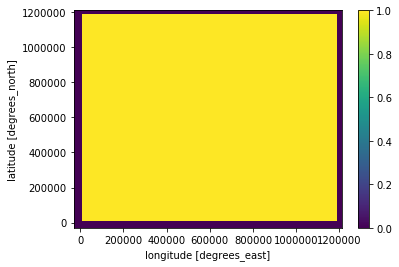

In [27]:
mask_z.plot()

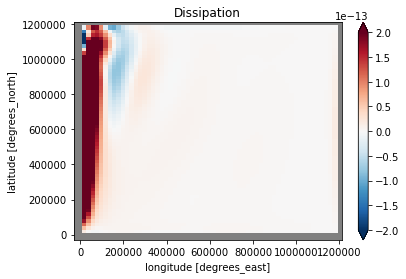

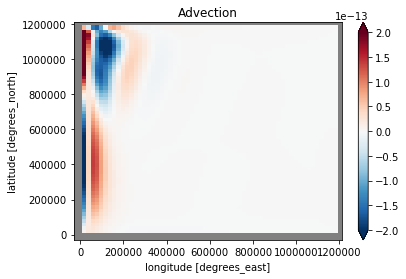

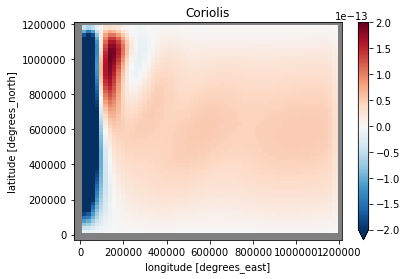

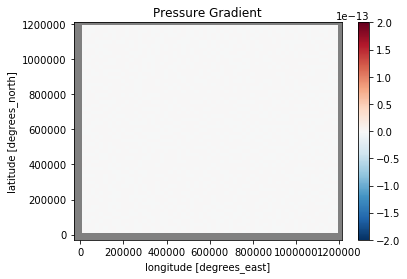

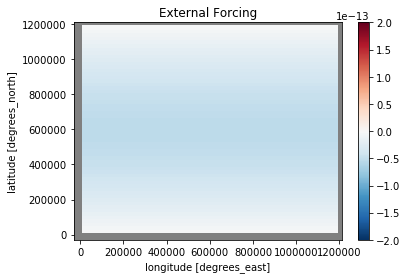

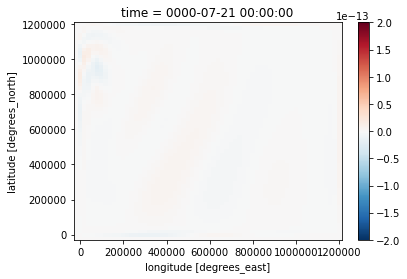

In [28]:
vmax=2e-13

for term, name in zip(terms_curl, names):
    plt.figure()
    term[-1].where(mask_z).plot(vmax=vmax)
    plt.title(name)
    
plt.figure()
sum(terms_curl)[-1].plot(vmax=vmax)

> Dissipation and advection is large at the boundary

> Coriolis balances external forcing in the interior [Sverdruop theory]

> Pressure gradient is zero

> Final sum of vorticity budget components is close to zero

> Does $\beta v$ match Coriolis?

In [29]:
ds_vort = xr.merge([term.rename(name) for term, name in zip(terms_curl, names)])
ds_vort

<xarray.Dataset>
Dimensions:            (XG: 62, YG: 62, time: 200)
Coordinates:
  * time               (time) object 0000-01-02 00:00:00 ... 0000-07-21 00:00:00
  * YG                 (YG) >f4 -20000.0 0.0 20000.0 ... 1180000.0 1200000.0
  * XG                 (XG) >f4 -20000.0 0.0 20000.0 ... 1180000.0 1200000.0
    rAz                (YG, XG) float32 dask.array<chunksize=(62, 62), meta=np.ndarray>
Data variables:
    Dissipation        (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Advection          (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Coriolis           (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Pressure Gradient  (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    External Forcing   (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>

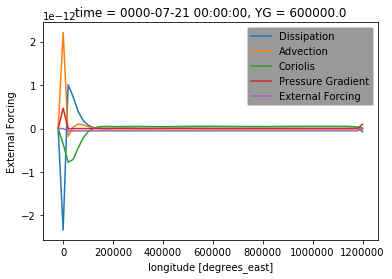

In [30]:
ds_to_plot = ds_vort.isel(time=-1).sel(YG=600000, method='nearest')

fig, ax = plt.subplots()
ax.set_facecolor('white')
for dvar in ds_to_plot:
    ds_to_plot[dvar].plot(label=dvar, ax=ax)
    
plt.legend()